### TOC:
* [First Bullet Header](#first-bullet)
* [Second Bullet Header](#second-bullet)

In [61]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [1]:
import os
import time
from datetime import datetime
import random

import numpy as np
import pandas as pd
import scipy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

import tensorflow as tf
#from tensorflow import keras #I think this package produces a discrepency between val_loss and val_metric (where both are MAE)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
import tensorflow.keras.optimizers
import tensorflow.keras.metrics

np.set_printoptions(precision=5, suppress=True)
pd.set_option("display.precision", 2)

## Import Data <a class="anchor" id="first-bullet"></a>

In [2]:
largeSample = False

In [3]:

if largeSample:
    dataSample = "Large"
    data_file_path = os.path.join(os.getcwd(), "Data\YXLarge.csv")
else:
    dataSample = "Ordinary"
    data_file_path = os.path.join(os.getcwd(), "Data\YX.csv")


data = pd.read_csv(data_file_path)
data = data.dropna(axis=1, how='all').drop(["compstq"], axis=1)


# data = dataset.map(..., num_parallel_calls=10)
# data = dataset.prefetch(buffer_size)

In [ ]:
#data_file_path = os.path.join(os.getcwd(), "Data\OriginalData\CompustatPrices.csv")
# prices = pd.read_csv(data_file_path, 
#                  nrows=270000, float_precision='round_trip', dtype = {"ajexdi": np.float64})[269000:270000]


# data_file_path = os.path.join(os.getcwd(), "Data\Other\AjexdiZero.csv")
# prices = pd.read_csv(data_file_path)

# data_file_path = os.path.join(os.getcwd(), "Data\Other\AjexdiZeroCompressed.csv")
# prices = pd.read_csv(data_file_path)


# #sum(prices["ajexdi"])
# prices.loc[prices["ajexdi"]==0.0]

# , dtype = {‘ajexdi’: np.float64}, ‘b’: np.int32, ‘c’: ‘Int64’}



In [ ]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805843 entries, 0 to 805842
Data columns (total 210 columns):
 #    Column                       Dtype  
---   ------                       -----  
 0    gvkey                        int64  
 1    fdateYQ                      float64
 2    returns                      float64
 3    volatility                   float64
 4    MktCap                       float64
 5    Split                        object 
 6    TimeDifferenceInDays         int64  
 7    loc                          object 
 8    city                         object 
 9    acctstdq                     object 
 10   compstq                      object 
 11   Sector                       float64
 12   Subsector                    float64
 13   IndustryGroup                float64
 14   Industry                     float64
 15   NationalIndustry             float64
 16   accdq                        float64
 17   acoq                         float64
 18   acoxq                 

In [110]:
naPercentage = data.isna().sum() / len(data) * 100
naPercentage

filteredData = data.loc[:, naPercentage<75]

In [ ]:
# import dask.dataframe
# finalData = dask.dataframe.read_csv(data_file_path)
# finalData
#finalData.dtypes

# trainY = finalData["returns"][0:20].compute()
# trainY
# trainX = finalData.loc[:, finalData.columns != "returns"]
# trainX


In [5]:
if largeSample:
    data = filteredData


descrNames = ["gvkey", "fdateYQ", "Split"] + ["MktCap"]
dummyNames = ["loc", "Sector", "acctstdq"] # , "compstq", "bsprq", "scfq", "staltq",
detailedDummyNames = ["city", "Subsector", "IndustryGroup", "Industry", "NationalIndustry"]
dependentNames = ["returns", "volatility",
                  "2Classes", "4Classes", "6Classes", "8Classes", "10Classes",
                  "Simple2Classes", "Simple4Classes", "Simple6Classes", "Simple8Classes", "Simple10Classes"]

dontCreateRatio = [#"quarterlyReturns-1", "quarterlyReturns-2", "quarterlyReturns-3", "quarterlyReturns-4",
                   #"quarterlyVolatility-1",  "quarterlyVolatility-2", "quarterlyVolatility-3", "quarterlyVolatility-4",
                   "past2YearReturn", "past3YearReturn", "past4YearReturn", "past5YearReturn",
                   "quarterlyReturnsLagged1Q", "quarterlyReturnsLagged2Q", "quarterlyReturnsLagged3Q", "quarterlyReturnsLagged4Q", 
                   "quarterlyVolatilityLagged1Q",  "quarterlyVolatilityLagged2Q", "quarterlyVolatilityLagged3Q", "quarterlyVolatilityLagged4Q", 
                   "yearlyReturnsLagged1Y", "yearlyReturnsLagged2Y", "yearlyReturnsLagged3Y", "yearlyReturnsLagged4Y", 
                   "past2YearVolatility", "past3YearVolatility", "past4YearVolatility", "past5YearVolatility"]


dontWinsorizeCols = ["TimeDifferenceInDays"]
dontNormalizeCols = dependentNames + descrNames + dummyNames + detailedDummyNames

ratioCols = data.columns.difference(dontCreateRatio + dontWinsorizeCols + dontNormalizeCols).to_list()
winsCols = data.columns.difference(dontWinsorizeCols + dontNormalizeCols).to_list()
numCols = data.columns.difference(dontNormalizeCols).to_list()


#finalData[factorCols] = finalData[factorCols].astype("category")
#finalData[numCols] = finalData[numCols].astype('float32')
#finalData[numCols] = finalData[numCols].astype('int32')


#finalData["fdateq"] = pd.to_datetime(finalData["fdateq"], format = "%Y%m%d")
#finalData["datadate"] = pd.to_datetime(finalData["datadate"], format = "%Y%m%d")
#finalData["fdateYQ"] = pd.to_datetime(finalData["fdateYQ"], format = "%Y%q") #check quarter format


In [112]:
#xLogData = finalData[numCols].apply(lambda x: np.log(x+0.001))
data[numCols].apply(lambda x: (min(x), max(x)))
# plt.hist(xLogData, bins=1000)
# plt.show()

,TimeDifferenceInDays,accdq,acoq,acoxq,actq,amq,ancq,aoq,apq,atq,...,xintq,xoproq,xoprq,xppq,xsgaq,xstq,yearlyReturnsLagged1Y,yearlyReturnsLagged2Y,yearlyReturnsLagged3Y,yearlyReturnsLagged4Y
0,-5,-1.14541e+04,-207943.0,-207943.0,-3.33000e-01,-758643.0,-1.04200e+00,-3.99115e+05,-4.13288e+03,0.00000e+00,...,-8.62793e+06,-8.09732e+06,-8.09732e+06,NaN,-3.65893e+03,-4.76666e+02,-100.0,-100.0,-100.0,-100.0
1,99,2.68383e+08,42092278.0,42057082.0,2.36287e+08,4212436.0,4.43236e+09,4.43128e+09,4.26825e+07,4.51633e+09,...,1.97205e+09,2.55095e+11,2.55095e+11,NaN,1.72297e+07,7.70791e+06,inf,inf,inf,inf


In [ ]:
#finalData.info(verbose=True)

In [ ]:
# #xLogData = xRatioData["revtq"]
# xLogData = finalData["revtq"].apply(lambda x: np.log(x+0.0001))

# import matplotlib.pyplot as plt

# plt.hist(xLogData, bins=1000)
# plt.show()

### Data transformations
#### Ratio

In [113]:
#Ratio data
ratioData = filteredData.copy()
ratioData[ratioCols] = ratioData[ratioCols].div(ratioData["MktCap"].values, axis=0) #This is an inplace operation if copy() is not used
#ratioData[ratioCols] = finalData[ratioCols].apply(lambda x: x/finalData["MktCap"].values, axis=0)



In [ ]:
# #import math
# #xLogData = math.log(ratioData["returns"])
# #xLogData = np.log(ratioData["returns"] + 105)
# #xLogData = np.log1p(ratioData["returns"]/105)
# #xLogData = ratioData[numCols].apply(lambda x: np.log(x), axis=1)
# #xLogData = ratioData["revtq"]
# xLogData = ratioData["revtq"].apply(lambda x: np.log(x+0.0001))

# import matplotlib.pyplot as plt
# plt.hist(xLogData, bins=1000)
# plt.show()

#### Winsorize

In [114]:
#Winsorised data
lowerLimit = 0.05
upperLimit = 0.05

winData=ratioData.copy()
#winData[winsCols] = ratioData[winsCols].apply(lambda x: scipy.stats.mstats.winsorize(x, limits = (lowerLimit, upperLimit))) #This is an inplace operation if copy() is not used
winData.loc[winData["Split"]=="Train", winsCols] = ratioData.loc[ratioData["Split"]=="Train", winsCols].apply(lambda x: scipy.stats.mstats.winsorize(x, limits = (lowerLimit, upperLimit))) #This is an inplace operation if copy() is not used
#Should we winsorize and scale the dependent variable?


for col in winData[winsCols].columns:
    maxThreshold = max(winData.loc[winData["Split"]=="Train", col])
    minThreshold = min(winData.loc[winData["Split"]=="Train", col])

    valMaxCondition = (winData["Split"]=="Validation") & (winData.loc[winData["Split"]=="Validation", col] > maxThreshold)    
    testMaxCondition = (winData["Split"]=="Test") & (winData.loc[ratioData["Split"]=="Test", col] > maxThreshold)

    valMinCondition = (winData["Split"]=="Validation") & (winData.loc[winData["Split"]=="Validation", col] < minThreshold)
    testMinCondition = (winData["Split"]=="Test") & (winData.loc[winData["Split"]=="Test", col] < minThreshold)

    winData.loc[valMaxCondition, col] = maxThreshold
    winData.loc[testMaxCondition, col] = maxThreshold

    winData.loc[valMinCondition, col] = minThreshold
    winData.loc[testMinCondition, col] = minThreshold
    print(col)


#winData.loc[winData["Split"]=="Train", numCols].describe()
#ratioData.loc[winData["Split"]=="Train", numCols].describe()

# a = ratioData.loc[ratioData["Split"]=="Train", winsCols]
# low_limit = 0.01
# up_limit = 0.01

# n = a.count()
# idx = a.argsort()
# lowidx = int(low_limit * n)
# a[idx[:lowidx]] = a[idx[lowidx]]

# upidx = n - int(n * up_limit)
# a[idx[upidx:]] = a[idx[upidx - 1]]



accdq
acoq
acoxq
actq
amq
ancq
aoq
apq
atq
capsq
ceqq
cheq
cogsq
cstkq
dfxaq
dlcq
dlttq
dpactq
dpq
eqrtq
eroq
gdwlq
gpq
ibmiiq
ibq
iditq
intanq
invtq
ivaeqq
ivaoq
lcoq
lcoxq
lctq
lltq
loq
lseq
ltmibq
ltq
mibnq
mibtq
miiq
nopioq
nopiq
oiadpq
oibdpq
oproq
past2YearReturn
past2YearVolatility
past3YearReturn
past3YearVolatility
past4YearReturn
past4YearVolatility
past5YearReturn
past5YearVolatility
piq
ppentq
quarterlyReturnsLagged1Q
quarterlyReturnsLagged2Q
quarterlyReturnsLagged3Q
quarterlyReturnsLagged4Q
quarterlyVolatilityLagged1Q
quarterlyVolatilityLagged2Q
quarterlyVolatilityLagged3Q
quarterlyVolatilityLagged4Q
reccoq
rectoq
rectq
rectrq
req
revtq
saleq
sctq
seqq
spiq
teqq
tstkq
txdbq
txtq
xintq
xoproq
xoprq
xppq
xsgaq
xstq
yearlyReturnsLagged1Y
yearlyReturnsLagged2Y
yearlyReturnsLagged3Y
yearlyReturnsLagged4Y


In [ ]:
# xLogData = winData["revtq"].apply(lambda x: np.log(x)) 
# #xLogData = scaledData["revtq"].apply(lambda x: np.log(x+0.005)) 
# import matplotlib.pyplot as plt

# #plt.hist(xLogData, bins=100)
# #plt.hist(ratioData["revtq"], bins=1000)
# plt.hist(winData["revtq"], bins=1000)
# plt.show()

In [ ]:
#winData[numCols].apply(lambda x: (min(x), max(x)))
#max(winData[numCols])
#min(winData[numCols])

#np.isinf(finalData[numCols]).values.sum()
#finalData[numCols].columns.to_series()[np.isinf(finalData[numCols]).any()]
#finalData[numCols].index[np.isinf(finalData[numCols]).any(1)]

#finalData[numCols].iloc[finalData[numCols].index[np.isinf(finalData[numCols]).any(1)], :]
#finalData[numCols].iloc[finalData[numCols].index[np.isinf(finalData[numCols]).any(1)], :][finalData[numCols].columns.to_series()[np.isinf(finalData[numCols]).any()]]

data.iloc[data[numCols].index[np.isinf(data[numCols]).any(1)].union(
    data[numCols].index[np.isinf(data[numCols]).any(1)] - 1), :][data[numCols].columns[np.isinf(data[numCols]).any()].union(["returns"])]


#finalData[numCols].columns[np.isinf(finalData[numCols]).any()].union(["returns"])

# np.isinf(winData[numCols]).values.sum()
# #winData[numCols].columns.to_series()[np.isinf(winData[numCols]).any()]
# winData[numCols].index[np.isinf(winData[numCols]).any(1)]

C:\Users\RobinForMLThesis\AppData\Local\Temp\ipykernel_7944\2403715917.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  finalData.iloc[finalData[numCols].index[np.isinf(finalData[numCols]).any(1)].union(
C:\Users\RobinForMLThesis\AppData\Local\Temp\ipykernel_7944\2403715917.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  finalData[numCols].index[np.isinf(finalData[numCols]).any(1)] - 1), :][finalData[numCols].columns[np.isinf(finalData[numCols]).any()].union(["returns"])]


,past2YearReturn,past3YearReturn,past4YearReturn,quarterlyReturnsLagged1Q,quarterlyReturnsLagged2Q,quarterlyReturnsLagged3Q,returns,yearlyReturnsLagged1Y,yearlyReturnsLagged2Y,yearlyReturnsLagged3Y,yearlyReturnsLagged4Y
147751,-100.00000,-100.00000,-100.00000,-1.00000e+02,-6.66667e+01,-4.00000e+01,0.00000e+00,-70.58824,1.42857e+02,-5.88235e+01,-5.52632e+01
147752,-93.14286,inf,NaN,-1.42857e+01,1.11111e+01,-5.43478e+01,-3.66667e+01,-84.22857,inf,-1.00000e+02,-7.05882e+01
147753,-78.26087,-96.57143,inf,-2.50000e+01,0.00000e+00,5.26316e+00,-2.33333e+01,-56.52174,-8.42286e+01,inf,-1.00000e+02
224063,-1.96217,4.39102,7.85266,-1.62137e+00,-1.11517e+01,9.39568e+00,-1.38741e+00,11.25844,6.48034e+00,3.31603e+00,2.45967e+01
224064,-100.00000,NaN,NaN,2.40000e+01,2.50000e+01,-5.12195e+01,1.03226e+02,0.00000,inf,-3.21965e-13,-7.50000e+01
224065,-100.00000,NaN,NaN,-1.74603e+01,1.03226e+02,2.40000e+01,7.69231e+00,-100.00000,inf,-2.22222e+01,-5.71429e+01
224066,-100.00000,-100.00000,NaN,1.32143e+02,7.69231e+00,-1.74603e+01,-5.00000e+01,-100.00000,0.00000e+00,inf,-3.21965e-13
224067,100.00000,-100.00000,NaN,-3.84615e+01,-5.00000e+01,1.32143e+02,-2.25000e+01,160.00000,-1.00000e+02,inf,-2.22222e+01
224068,-38.70968,-100.00000,-100.00000,-3.87097e+01,-2.25000e+01,-3.84615e+01,2.10526e+01,319.35484,-1.00000e+02,0.00000e+00,inf
343006,-3.22915,21.93196,33.67713,2.66667e+01,7.51748e+00,5.27241e-01,5.26316e+00,-37.14293,2.60007e+01,9.63256e+00,-6.23107e+00


#### Normalize

In [219]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()

#My scaling and winsorizing is biased. They should be done based on the training data, not testing and validation
scaledData=winData.copy()
scaledData.replace([np.inf, -np.inf], np.nan, inplace=True)
#scaledData.dropna(inplace=True)

scaler.fit(scaledData.loc[scaledData["Split"]=="Train", numCols])
scaledData[numCols] = scaler.transform(scaledData[numCols]) #This is an inplace operation if copy() is not used

float64Cols = scaledData.select_dtypes(include=[np.float64]).columns
scaledData[float64Cols] = scaledData[float64Cols].astype('float32')
#scaledData[numCols] = scaledData[numCols].astype('float16')
#scaledData.info(verbose=True)
#scaledData.select_dtypes(include=[np.int64]).columns

# scaledData.loc[:, scaledData.dtypes == 'float64'] = scaledData.loc[:, scaledData.dtypes == 'float64'].astype('float32')
# scaledData.loc[:, scaledData.dtypes == 'int64'] = scaledData.loc[:, scaledData.dtypes == 'int64'].astype('int32')


In [218]:
#np.isinf(scaledData[numCols]).sum()

scaledData[numCols].columns.to_series()[np.isinf(scaledData[numCols]).any()]

ancq        ancq
dlcq        dlcq
eroq        eroq
ivaoq      ivaoq
lctq        lctq
ltmibq    ltmibq
mibnq      mibnq
reccoq    reccoq
rectoq    rectoq
teqq        teqq
dtype: object

#### Impute

In [220]:
if largeSample:

    #impute
    imputedData=scaledData.copy()
    imputedData.dropna(axis=1, how='all')
    #imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    #imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=False, copy=False)
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=False, copy=True, keep_empty_features=True)
    #imp = IterativeImputer(max_iter=2, random_state=0, add_indicator=True, verbose=0)
    imp.fit(imputedData.loc[imputedData["Split"]=="Train", numCols])
    #IterativeImputer(random_state=0)
    print("Hey")

    #imputedData = imp.transform(imputedData[numCols])
    imputedData[numCols] = imp.transform(imputedData[numCols])
    # imputedData.loc[imputedData["Split"]=="Validation", numCols] = imp.transform(imputedData.loc[imputedData["Split"]=="Validation", numCols])
    # imputedData.loc[imputedData["Split"]=="Test", numCols] = imp.transform(imputedData.loc[imputedData["Split"]=="Test", numCols])



Hey


In [221]:
if largeSample:
    pd.DataFrame.to_csv(scaledData, "Data/scaledDataMedium.csv", index=False)
    pd.DataFrame.to_csv(imputedData, "Data/imputedDataMedium.csv", index=False)
else:
    pd.DataFrame.to_csv(scaledData, "Data/scaledData.csv", index=False)



In [ ]:
# #xLogData = scaledData["revtq"].apply(lambda x: np.log(x)) 
# #xLogData = scaledData["revtq"].apply(lambda x: np.log(x+0.005)) 
# #xLogData = scaledData["revtq"].apply(lambda x: np.log(x+0.9)) 
# import matplotlib.pyplot as plt

# #plt.hist(xLogData, bins=100)
# plt.hist(scaledData["revtq"], bins=300)
# plt.show()

In [223]:
#xScaledData
# scaledData.describe().to_csv("Descr//FinalizedDesc.csv")
# scaledData.describe().to_html("Descr//FinalizedDesc.html")

descriptives = scaledData.describe()
descriptives.to_csv("Descr//MediumFinalizedDesc.csv")
descriptives.to_html("Descr//MediumFinalizedDesc.html")
descriptives

,gvkey,fdateYQ,returns,volatility,MktCap,TimeDifferenceInDays,Sector,Subsector,IndustryGroup,Industry,...,ivaeqq,mibnq,mibtq,miiq,oproq,spiq,tstkq,txdbq,xppq,xstq
count,805843.00000,805843.00000,8.05839e+05,805254.00000,8.05582e+05,805843.00000,805453.00000,805453.00000,805453.00000,805453.00000,...,230182.00000,3.91434e+05,445831.00000,400018.00000,248363.00000,338996.00000,243662.00000,410297.00000,267837.00000,301616.00000
mean,250462.32698,2016.20544,6.24523e+00,0.47428,4.59206e+11,-0.02586,39.66792,398.41388,3588.32764,29637.75195,...,-0.00632,5.47082e+00,0.00676,0.00011,0.00167,-0.01352,0.00452,0.00441,-0.03651,-0.05447
std,61784.94129,4.28722,2.43723e+03,17.21597,8.35808e+12,0.95944,13.28535,134.05699,1729.64331,21040.23828,...,1.40411,3.41949e+03,1.24463,0.87572,1.43388,5.59552,1.41698,1.24234,1.40332,0.98192
min,1166.00000,2006.50000,-1.00000e+02,0.00000,0.00000e+00,-3.02843,11.00000,11.00000,11.00000,11.00000,...,-3.83063,-1.61818e+02,-0.06511,-0.18745,-0.06405,-3109.87769,-0.14549,-0.09838,-0.45490,-0.30998
25%,212970.00000,2013.00000,-1.00000e+01,0.24591,2.78491e+08,-0.75496,32.00000,325.00000,3122.00000,4811.00000,...,-0.20166,-5.52546e-02,-0.06004,-0.03205,-0.06356,-0.00966,-0.13904,-0.09630,-0.30380,-0.28502
50%,260504.00000,2016.75000,0.00000e+00,0.35925,2.44236e+09,-0.05900,33.00000,334.00000,3343.00000,32799.00000,...,-0.17380,-4.98248e-02,-0.05373,-0.03035,-0.05958,-0.00939,-0.10516,-0.08160,-0.24810,-0.22719
75%,290815.00000,2019.75000,1.08354e+01,0.52583,1.34482e+10,0.63696,52.00000,522.00000,5151.00000,48511.00000,...,-0.06114,-2.49657e-02,-0.02556,-0.01708,-0.04428,-0.00925,-0.00748,-0.03206,-0.09304,-0.08567
max,354340.00000,2022.50000,2.18621e+06,15320.10742,1.35863e+15,1.79690,99.00000,999.00000,9999.00000,99999.00000,...,325.22522,2.13940e+06,379.47485,218.12157,460.43573,788.00787,396.26154,186.67596,363.44061,69.33879


In [ ]:
# #tf.sparse.SparseTensor
# import tensorflow as tf
# from tensorflow import keras

# np.set_printoptions(precision=3, suppress=True)
# ###tf.enable_eager_execution()
# #tf.keras.Model.run_eagerly

# dataset = tf.data.experimental.make_csv_dataset(
#     data_file_path, label_name="returns", batch_size=2, num_epochs=1,
#     shuffle=False, sloppy=True) # compression_type = GZIP #ZLIB
# iterator = dataset.as_numpy_iterator()

# #dataset.zip()
# #dataset
# #iterator.next()

# # for batch, label in dataset.take(1):
# #   for key, value in batch.items():
# #     print(f"{key:20s}: {value}")
# #   print()
# #   print(f"{'label':20s}: {label}")

# #b = dataset.map(lambda x: x*2)


# dummyLayer = tf.keras.layers.StringLookup(
#     mask_token=None,
#     encoding="utf-8",
#     output_mode="one_hot",
#     sparse=True
# )

# # dummyDataset = dataset.map(lambda x, y: (
# #     {n: x[n] for n in numCols} | {f: dummyLayer.adapt(x[f]) for f in factorCols},
# #     y))



# # feature_ds = dataset.map(lambda x, y: x[name])
# # feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
# # # Learn the set of possible string values and assign them a fixed integer index
# # lookup.adapt(feature_ds)



# #dummyDataset = dataset.map(lambda x, y: ({f: x[f] for f in factorCols}))
# #dummyDataset = dataset.map(lambda x, y: (x[f] for f in factorCols))
# #dummyDataset = dataset.map(lambda x, y: x[factorCols])
# #dummyDataset = dataset.map(lambda x, y: x["loc"])

# #dummyDataset.batch(32)

# #d = dummyLayer.adapt(dummyDataset)


# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(categories='auto', sparse=False)
# # ohe.fit_transform(dataset[['loc']])

# dummyDataset = dataset.map(lambda x, y: ({f: ohe.fit_transform(x[f]) for f in factorCols}))


# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# le.fit_transform(df['col1'])
# dictionary_length = len(le.classes_)



# #from sklearn.model_selection import TimeSeriesSplit
# #tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)



# # dummyLayer = tf.keras.layers.StringLookup(
# #     mask_token=None,
# #     encoding="utf-8",
# #     output_mode="int"
# # )

# # dummyDataset = dataset.map(lambda x, y: (
# #     {n: x[n] for n in numCols} | {f: dummyLayer(x[f]) for f in factorCols},
# #     y))


# # for batch, label in dummyDataset.take(1):
# #   for key, value in batch.items():
# #     print(f"{key:20s}: {value}")
# #     print()
# #     print(f"{'label':20s}: {label}")



# # embeddedDummies = tf.keras.layers.Embedding(
# #     input_dim=2000,
# #     output_dim=10,
# #     activity_regularizer=None,
# #     mask_zero=True,
# # )

# # dummyModel = tf.keras.Sequential()
# # dummyModel.add(embeddedDummies)

# # with tf.device('cpu:0'):
# #   embedding_layer = Embedding(...)
# #   embedding_layer.build()


In [ ]:
if largeSample:
    finalData = imputedData.copy()
else: 
    finalData = scaledData.copy()

In [6]:
if largeSample:
    finalData = pd.read_csv(os.path.join(os.getcwd(), "Data\imputedDataMedium.csv"))
else: 
    finalData = pd.read_csv(os.path.join(os.getcwd(), "Data\scaledData.csv"))

### Final Data

In [353]:
finalData = finalData.dropna()

dummyData = pd.get_dummies(finalData, dummy_na=False, sparse=False, drop_first=False,
                         columns=dummyNames)#, "bsprq", "scfq", "staltq"])


target = ["6Classes"]
#target = ["returns"]

if target != ["returns"] and target != ["volatility"] and target != ["returns", "volatility"]:
    classification = True
    Y = pd.get_dummies(dummyData[target + ["Split", "fdateYQ"]], dummy_na=False, sparse=False, drop_first=False,
                       columns=target)
else:
    classification = False
    Y = finalData[target + ["Split", "fdateYQ"]]


yTrain = Y[Y["Split"]=="Train"].drop(["Split", "fdateYQ"], axis=1)
yVal = Y[Y["Split"]=="Validation"].drop(["Split", "fdateYQ"], axis=1)
yTest = Y[Y["Split"]=="Test"].drop(["Split", "fdateYQ"], axis=1)

X = pd.get_dummies(finalData[numCols + dummyNames + ["Split", "fdateYQ"]], dummy_na=False, sparse=False, drop_first=False,
                         columns=dummyNames)#, "bsprq", "scfq", "staltq"])

namesOfAllPredictorsAndDummies = list(X.columns)

xTrain = X.loc[X["Split"]=="Train"].drop(["Split", "fdateYQ"], axis=1)
xVal = X.loc[X["Split"]=="Validation"].drop(["Split", "fdateYQ"], axis=1)
xTest = X.loc[X["Split"]=="Test"].drop(["Split", "fdateYQ"], axis=1)



In [ ]:
# catEncodingLayer = tf.keras.layers.CategoryEncoding(
#     num_tokens=3, output_mode="one_hot", sparse=False
# )

# catEncodingLayer(xScaledData[["2Classes"]])



In [ ]:
# intLookupLayer = tf.keras.layers.IntegerLookup(
#     max_tokens=3,
#     num_oov_indices=1,
#     mask_token=None,
#     vocabulary=[1,10],
#     output_mode="one_hot",
#     sparse=False,
#     pad_to_max_tokens=False
# )

# #intLookupLayer.adapt(xScaledData[["10Classes"]])
# intLookupLayer(xScaledData[["10Classes"]])


In [ ]:
#dummyData.iloc[:, 15:40].describe()

In [ ]:
#pd.DataFrame.to_csv(dummyData, "Data/dummiesData.csv", index=False)
# #dummies.to_hdf(r"Data/dummiesData2.csv", key='dummies', mode='w')

#X.info(verbose=True)
#dummies.info(verbose=True)


In [ ]:
# import tensorflow as tf
# from tensorflow import keras

# np.set_printoptions(precision=3, suppress=True)
# ###tf.enable_eager_execution()
# #tf.keras.Model.run_eagerly

# #xScaledDataWithDummies = pd.concat([xScaledData, dummies], axis=1) 


# #numeric_dict_ds = tf.data.Dataset.from_tensor_slices((dict(numeric_features), target))
# categorical_feature_names = factorCols
# binary_feature_names = []

# inputs = {}
# for name, column in xScaledData.items():
#   if type(column[0]) == str:
#     dtype = tf.string
#   elif (name in categorical_feature_names or
#         name in binary_feature_names):
#     dtype = tf.int64
#   else:
#     dtype = tf.float32

#   inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)


# preprocessed = []
# for name in categorical_feature_names:
#   vocab = sorted(set(xScaledData[name]))
#   #print(f'name: {name}')
#   #print(f'vocab: {vocab}\n')

#   if type(vocab[0]) is str:
#     lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
#   else:
#     lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

#   x = inputs[name][:, tf.newaxis]
#   x = lookup(x)
#   preprocessed.append(x)


# numeric_feature_names = numCols

# def stack_dict(inputs, fun=tf.stack):
#     values = []
#     for key in sorted(inputs.keys()):
#       values.append(tf.cast(inputs[key], tf.float32))

#     return fun(values, axis=-1)
# #normalizer = tf.keras.layers.Normalization(axis=-1)
# #normalizer.adapt(numeric_features)

# numeric_inputs = {}
# for name in numeric_feature_names:
#   numeric_inputs[name]=inputs[name]

# numeric_inputs = stack_dict(numeric_inputs)
# #numeric_normalized = normalizer(numeric_inputs)

# #preprocessed.append(numeric_normalized)
# preprocessed.append(numeric_inputs)
# #preprocessed

# preprocessed_result = tf.concat(preprocessed, axis=-1)
# #preprocessed_result

# preprocessor = tf.keras.Model(inputs, preprocessed_result)

# tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

# preprocessor(dict(xScaledData.iloc[:1]))

# xWinTrainDict, xWinValDict, xWinTestDict = xScaledData.loc[split=="Train", :], xScaledData.loc[split=="Validation", :], xScaledData.loc[split=="Test", :]
# xWinTrainDict, xWinValDict, xWinTestDict = dict(xWinTrainDict), dict(xWinValDict), dict(xWinTestDict)
# xWinTrainDict, xWinValDict, xWinTestDict = preprocessor(xWinTrainDict), preprocessor(xWinValDict), preprocessor(xWinTestDict)


# # dataset = tf.data.experimental.make_csv_dataset(xScaledDataWithDummies, label_name="returns", batch_size=2, num_epochs=1,
# #     shuffle=False, sloppy=True) # compression_type = GZIP #ZLIB
# # iterator = dataset.as_numpy_iterator()


# # inputs = {}
# # for name, column in df.items():
# #   if type(column[0]) == str:
# #     dtype = tf.string
# #   elif (name in categorical_feature_names or
# #         name in binary_feature_names):
# #     dtype = tf.int64
# #   else:
# #     dtype = tf.float32

# #   inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)


In [ ]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [93]:
y_pred = np.array([
    [0.1, 0.2, 0.9, 0],
    [0.2, 0.9, 0.1, 0]
])

y_true = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

y_pred2 = np.array([
    [0.1, 0.2, 0.9, 0],
    [0.2, 0.9, 0.1, 0]
])

y_true2 = np.array([
    [0, 0, 1, 0],
    [0, 1, 0, 0]
])


y_pred_max = tf.argmax(y_pred, axis=1)
y_true_max = tf.argmax(y_true, axis=1)

y_pred_max = tf.cast(y_pred_max, "float16")
y_true_max = tf.cast(y_true_max, "float16")

shape = tf.constant(y_pred.shape[1]/2 - 1/2, dtype = "float16", shape = y_pred.shape[0])

values = ((y_pred_max < shape) & (y_true_max < shape)) | ((y_pred_max > shape) & (y_true_max > shape))
values

values = tf.cast(values, "float16")
values
tf.reduce_sum(values)

# values = []
# # for n in zip(y_max, y_true_max):
# #     if n[0] > shape and n[1] > shape:
# #         values = values + [1]
# #     elif n[0] < shape and n[1] < shape:
# #         values = values + [1]
# #     else:
# #         values = values + [0]


<tf.Tensor: shape=(), dtype=float16, numpy=1.0>

In [261]:
m = MeanDirectionalAccuracy()
m.reset_state()
m.update_state(y_true2, y_pred2)
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [171]:
a = []
a = tf.concat([a, [1, 2, 3]], 0)
a = tf.concat([a, [1, 2, 3]], 0)
a

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 2., 3., 1., 2., 3.], dtype=float32)>

In [260]:
class MeanDirectionalAccuracy(tf.keras.metrics.Metric):

  def __init__(self, name='mean_directional_accuracy', **kwargs):
    super().__init__(name=name, **kwargs)
    self.mda = self.add_weight(name='mda', initializer='zeros')
    #self.n = self.add_weight(name='n', initializer='zeros')
    #self.da = self.add_weight(name='da', initializer='zeros')
    #self.da = tf.variable(0.5, dtype = "float16", shape = y_pred.shape[0])
    #self.da = []
    #self.da = tf.TensorArray(dtype=self.dtype, size=0, dynamic_size=True)
    self.da = tf.constant([])
    #self.da = tf.zeros([0])
    #self.da = None

  def update_state(self, y_true, y_pred, sample_weight=None):
    
    y_true_max = tf.argmax(y_true, axis=1)
    y_pred_max = tf.argmax(y_pred, axis=1)

    #print(y_true_max, y_pred_max)

    y_true_max = tf.cast(y_true_max, "float16")
    y_pred_max = tf.cast(y_pred_max, "float16")
    shape = tf.constant(y_pred.shape[1]/2 - 1/2, dtype = "float16", shape = y_pred.shape[0])

    values = ((y_pred_max < shape) & (y_true_max < shape)) | ((y_pred_max > shape) & (y_true_max > shape))
    values = tf.cast(values, self.dtype)
    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, self.dtype)
      values = tf.multiply(values, sample_weight)
    #values = tf.squeeze(values)
    #self.mda.assign_add(tf.reduce_sum(values) / y_pred.shape[0])
    #self.da = self.da + values
    # print(values)
    # print(self.da)
    #print(values)
    #print("Hey!")
    #values = tf.reshape(values, shape=(-1))
    self.da = tf.concat([self.da, values], axis = 0)
    #print(self.da)
    self.mda.assign(tf.reduce_mean(self.da))
    #prevMDA = self.mda * self.n/(self.n + y_pred.shape[0])
    # try:
    #   print(len(y_pred))
    #   prevMDA = self.mda * tf.math.divide(self.n, self.n + y_pred.shape[0])
    #   newMDA = tf.reduce_mean(values) * tf.math.divide(y_pred.shape[0], self.n + y_pred.shape[0])
    #   self.mda.assign(prevMDA + newMDA)
    #   self.n.assign(self.n + y_pred.shape[0])
    # except Exception as e: 
    #   print(e)
    #   self.mda.assign(0.5)
    #   self.n.assign(1)

    

    #self.mda.assign(tf.reduce_mean(values))
    #print(self.mda)
    #self.mda = tf.reduce_sum(values) / y_pred.shape[0]

  def result(self):
    return self.mda

  def reset_state(self):
    # self.da = []
    # self.n.assign(0)
    self.mda.assign(0)

In [317]:
from keras.utils import metrics_utils
from keras import backend

# @keras_export("keras.metrics.categorical_accuracy")
# @tf.__internal__.dispatch.add_dispatch_support
# def categorical_accuracy(y_true, y_pred):


#     values = ((y_pred_max < shape) & (y_true_max < shape)) | ((y_pred_max > shape) & (y_true_max > shape))

#     return metrics_utils.sparse_categorical_matches(
#         tf.math.argmax(y_true, axis=-1), y_pred
#     )


from tensorflow.python.util.tf_export import keras_export
from keras.metrics import base_metric
from keras.dtensor import utils as dtensor_utils

#@keras_export("keras.metrics.CategoricalAccuracy")
class MDA(base_metric.MeanMetricWrapper):

    # @dtensor_utils.inject_mesh
    # def __init__(self, name="categorical_accuracy", dtype=None):
    #     super().__init__(
    #         lambda y_true, y_pred: metrics_utils.sparse_categorical_matches(
    #             tf.math.argmax(y_true, axis=-1), y_pred
    #         ),
    #         name,
    #         dtype=dtype,
    #     )
    # @dtensor_utils.inject_mesh
    # def __init__(self, name="categorical_accuracy", dtype=None):
    #     super().__init__(
    #         lambda y_true, y_pred: (
    #             y_true_max = tf.argmax(y_true, axis=1)
    #             y_pred_max = tf.argmax(y_pred, axis=1)

    #             y_true_max = tf.cast(y_true_max, "float16")
    #             y_pred_max = tf.cast(y_pred_max, "float16")
    #             shape = tf.constant(y_pred.shape[1]/2 - 1/2, dtype = "float16", shape = y_pred.shape[0])
    #             values = ((y_pred_max < shape) & (y_true_max < shape)) | ((y_pred_max > shape) & (y_true_max > shape))
    #             values = tf.cast(values, self.dtype)
    #             values)
    #         ,
    #         name,
    #         dtype=dtype,
    #     )
    @dtensor_utils.inject_mesh
    def __init__(self, name="mean_directional_accuracy", dtype=None):
        super().__init__(
            lambda y_true, y_pred: (
                ((tf.argmax(y_pred, axis=1)*2 < y_pred.shape[1] - 1) & 
                (tf.argmax(y_true, axis=1)*2 < y_pred.shape[1] - 1)) | 
                ((tf.argmax(y_pred, axis=1)*2 > y_pred.shape[1] - 1) & 
                (tf.argmax(y_true, axis=1)*2 > y_pred.shape[1] - 1))
                )
            ,
            name,
            dtype=dtype,
        )





In [273]:
# metrics_utils.sparse_categorical_matches(
#                 tf.math.argmax(y_true, axis=-1), y_pred
#                 )


y_true_max = tf.argmax(y_true, axis=1)
y_pred_max = tf.argmax(y_pred, axis=1)

y_true_max = tf.cast(y_true_max, "float16")
y_pred_max = tf.cast(y_pred_max, "float16")
shape = tf.constant(y_pred.shape[1]/2 - 1/2, dtype = "float16", shape = y_pred.shape[0])
((y_pred_max < shape) & (y_true_max < shape)) | ((y_pred_max > shape) & (y_true_max > shape))

<tf.Tensor: shape=(2,), dtype=bool, numpy=array([ True, False])>

## Model building function

In [354]:
def NNfunction(modelType, layers, units, activation, dropout, L1, L2, batch_size, optimizer, learning_rate, runningDate,
               loss="MeanAbsoluteError", performCV=False, patience=1, verbose=1):
    
    epochs = 300
    finalActivation = "linear"
    numberOfOutputs = yTrain.shape[1]

    #loss = "MeanAbsoluteError"   # 'tf.keras.losses.MeanSquaredError()'  #Huber #MeanAbsoluteError #MeanSquaredError 
    metrics = ["MeanAbsoluteError", "MeanSquaredError"] #, "RootMeanSquaredError"]) #accuracy #MeanSquaredLogarithmicError #RootMeanSquaredError #MeanAbsolutePercentageError 
    EarlyStopping_monitor = "val_mean_absolute_error"

    if classification:
        finalActivation = "softmax"
        loss = "categorical_crossentropy"
        #metrics = ["accuracy", "categorical_accuracy", MeanDirectionalAccuracy()]
        metrics = ["accuracy", "categorical_accuracy", MDA()]
        EarlyStopping_monitor = "val_loss"


    # Adam(learning_rate=0.0001) #RMSprop #sgd
    if optimizer == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)


    #input1 = tf.keras.layers.Input(shape=(1,))
    #input2 = tf.keras.layers.Input(shape=(1,))
    #merged = tf.keras.layers.Concatenate(axis=1)([input1, input2])
    #dense1 = tf.keras.layers.Dense(2, input_dim=2, activation=keras.activations.sigmoid, use_bias=True)(merged)

    input = tf.keras.layers.Input(shape=(xTrain.shape[1],))
    #model.add(tf.keras.layers.BatchNormalization())

    if modelType == "LSTM":
        hidden = tf.keras.layers.LSTM(units=units[0])(input)
    elif modelType == "GRU":
        hidden = tf.keras.layers.GRU(units=units[0])(input)
    elif modelType == "SimpleRNN":
        hidden = tf.keras.layers.SimpleRNN(units=units[0])(input)
    elif modelType == "FeedForward":
        denseLayer = tf.keras.layers.Dense(units=units[0],
                            activation=activation,
                            kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2))
        dropOutLayer = tf.keras.layers.Dropout(rate=dropout)

        try:
            hidden = denseLayer(input)
            hidden = dropOutLayer(hidden)
            for n in range(1, layers):
                hidden = tf.keras.layers.Dense(units=units[n],
                            activation=activation,
                            kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2))(hidden)
                hidden = dropOutLayer(hidden)
                # scaler.fit_transform
                # tf.keras.layers.BatchNormalization(
            print(f"NN{layers}Layer")
        except Exception as e: 
            print(e)
            print("NN1Layer_WhyDidWeEndUpHere?")


    outputLayer = tf.keras.layers.Dense(units=numberOfOutputs, activation=finalActivation,
                                        kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2))

    if modelType == "RegularizedLinear" or modelType == "StandardLinear":
        output = outputLayer(input)
        print("Linear")
    # elif modelType == "StandardLinear":
    #     output = outputLayer(input)
    #     print("StandardLinear")
    else:
        output = outputLayer(hidden)

    #model = tf.keras.models.Model(inputs=[input1, input2], output=output)
    model = tf.keras.models.Model(inputs=[input], outputs=output, name=f"{modelType}_{runningDate}")

    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)



    if performCV:

        loss_and_metrics_matrix = pd.DataFrame()
        epochs_matrix = pd.DataFrame()
        quarters = dummyData[dummyData["Split"] == "Validation"]["fdateYQ"].unique()
        quarters.sort()

        for q in quarters:
            # Run cross validation through model fit and evaluate. 
            # Save all MSAs and MSEs from "loss_and_metrics" into a dataframe and take their average to obtain the best model
            print("Quarter " + str(q))
            xT = dummyData[dummyData["fdateYQ"] < q].drop(descrNames + dependentNames + detailedDummyNames, axis=1)
            yT = dummyData[dummyData["fdateYQ"] < q][target]
            #A rolling window might be faster. E.g.: dummies["fdateYQ"] == q - 0.25

            xV = dummyData[dummyData["fdateYQ"] == q].drop(descrNames + dependentNames + detailedDummyNames, axis=1)
            yV = dummyData[dummyData["fdateYQ"] == q][target]

            if classification:
                yT = pd.get_dummies(yT, dummy_na=False, sparse=False, drop_first=False,
                            columns=target)
                yV = pd.get_dummies(yV, dummy_na=False, sparse=False, drop_first=False,
                            columns=target)
                

            earlystopping_callback = tf.keras.callbacks.EarlyStopping(
                    monitor=EarlyStopping_monitor, patience=patience, verbose=1, restore_best_weights=True) #Can this be taken out from the loop? => Less computing

            # tensorboardLogPath = f"Results/logs/{runningDate}/{modelType}_{layers}L_{units}U_{activation}_{dropout}DO_{L1}L1_{L2}L2_{batch_size}Batch_{optimizer._name}_{learning_rate}LR_Q{q}"
            # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboardLogPath) #tensorboard --logdir="10-01-2023_1606" #tensorboard --logdir="logs/"
            #BackupAndRestore_callback = tf.keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")

            history = model.fit(x=xT, y=yT,
                                batch_size=batch_size, epochs=epochs,
                                callbacks=[earlystopping_callback], verbose=verbose, validation_data=(xV, yV))

            loss_and_metrics = model.evaluate(xV, yV, batch_size=batch_size, return_dict=True)
            epochs_EarlyStopping = len(history.history['loss']) - patience

            loss_and_metrics = pd.DataFrame(loss_and_metrics, index=[q])
            loss_and_metrics_matrix = pd.concat((loss_and_metrics_matrix, loss_and_metrics))

            epochs_EarlyStopping = pd.DataFrame({"Epochs": epochs_EarlyStopping}, index=loss_and_metrics.index)
            epochs_matrix = pd.concat((epochs_matrix, epochs_EarlyStopping))
        print(pd.concat((loss_and_metrics_matrix, epochs_matrix), ignore_index=False, axis=1), "\n")

        loss_and_metrics = loss_and_metrics_matrix.mean()
        loss_and_metrics = loss_and_metrics.to_dict()
        epochs_EarlyStopping = epochs_matrix.mean()[0]

    else:
        earlystopping_callback = tf.keras.callbacks.EarlyStopping(
                    monitor=EarlyStopping_monitor, patience=patience, verbose=1, restore_best_weights=True) #Can this be taken out from the loop? => Less computing

        tensorboardLogPath = f"Results/logs/{runningDate}/{modelType}_{layers}L_{units}U_{activation}_{dropout}DO_{L1}L1_{L2}L2_{batch_size}Batch_{optimizer._name}_{learning_rate}LR"
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboardLogPath) #tensorboard --logdir="10-01-2023_1606" #tensorboard --logdir="logs/"
        #BackupAndRestore_callback = tf.keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")
        history = model.fit(x=xTrain, y=yTrain,
                batch_size=batch_size, epochs=epochs,
                callbacks=[earlystopping_callback, tensorboard_callback], verbose=verbose, validation_data = (xVal, yVal))
        loss_and_metrics = model.evaluate(xVal, yVal, batch_size=batch_size, return_dict=True)
        epochs_EarlyStopping = len(history.history['loss']) - patience
        print(loss_and_metrics, "\n", epochs_EarlyStopping, "\n")
        #history.history[]

    # history = model.fit(x=xWinTrainDict, y=yTrain,
    #           batch_size=16, epochs=300,
    #           callbacks=[callback], verbose=1, validation_data = (xWinValDict, yVal))

    return loss_and_metrics, epochs_EarlyStopping, model

    #model.predict(xVal, batch_size=128)



In [ ]:
# from itertools import chain, combinations, permutations
# def powerset(iterable):
#     "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
#     s = list(iterable)
#     res = chain.from_iterable(permutations(s, r) for r in range(1, len(s)+1))
#     return res

### Parameter grid creation

In [111]:
import itertools
import random
import pandas as pd

#Hyper-Parameters
NNModelType = {"FeedForward"} #, "LSTM", "GRU"}
hiddenLayers = {1, 2, 3, 4, 5}
hiddenUnits = 2**np.arange(9)
#hiddenUnitsGrid = list(itertools.product(hiddenUnits, repeat=max(hiddenLayers)))
#hiddenUnitsGrid = random.sample(population = hiddenUnits, k=max(hiddenLayers), counts=10)
#hiddenUnitsGrid = random.sample(list(itertools.product(hiddenUnits, repeat=max(hiddenLayers))), k=50)

activationFunc = {"linear", "relu", "sigmoid", "tanh"} #etc. https://keras.io/api/layers/activations/ , "selu"
dropOut = np.arange(start=0, stop=1, step=0.1)
#epochs = [100] #Just choose best model. => Run for 100 epochs, but if 20th epoch is the best, choose it, i.e. early stopping
#inputSize = numberOfVariables #ncol(trainXPools[[1]])
#other parameters: loss func, node structure, location of the regularization function
batchSize = 2**np.arange(start=4, stop=9)
optim = {"Adam", "RMSprop"}#, "sgd"}
learningRate = {0.01, 0.001, 0.0001}#, 0.00001}
L1L2Grid = 10**np.arange(start=2, stop=-6, step=-1.0) #3 and -10
L1L2Grid = np.append(0, L1L2Grid)
none = {None}
zero = {0}

StandardLinearParams = {
    "Model type": {"StandardLinear"},
    "Hidden layers": zero,
    "Hidden units": zero,
    "Activation function": none,
    "Dropout": zero,
    "L1": {0.0},
    "L2": {0.0},
    "Batch size": {32},
    "Optimizer": {"Adam"},
    "Learning rate": {0.001}
}

LinearParams = StandardLinearParams | {
    "Model type": {"RegularizedLinear"},
    "L1": L1L2Grid,
    "L2": L1L2Grid,
    "Batch size": batchSize,
    "Optimizer": optim,
    "Learning rate": learningRate
}

NNParams = LinearParams | {
    "Model type": NNModelType,  # , "LSTM", "GRU"},
    "Hidden layers": hiddenLayers,
    "Hidden units": hiddenUnits, #hiddenUnitsGrid,
    "Activation function": activationFunc,
    "Dropout": dropOut
}

NaiveZeroParams = StandardLinearParams | {
    "Model type": {"NaiveZeroForecast"},
    "Batch size": none,
    "Optimizer": none,
    "Learning rate": none,
    "Epochs": none,
    "Training Time (minutes)": none,
    "ModelPointer": none
}

NaiveMeanParams = NaiveZeroParams | {"Model type": {"NaiveMeanForecast"}}
NaiveFirmMeanParams = NaiveZeroParams| {"Model type": {"NaiveFirmMeanForecast"}}
NaiveFiveYearParams = NaiveZeroParams| {"Model type": {"NaiveFiveYearForecast"}}

StandardLinearGrid = pd.DataFrame(itertools.product(
    *StandardLinearParams.values()), columns=StandardLinearParams.keys())

linearGrid = pd.DataFrame(itertools.product(
    *LinearParams.values()), columns=LinearParams.keys())

NaiveZeroGrid = pd.DataFrame(itertools.product(
    *NaiveZeroParams.values()), columns=NaiveZeroParams.keys())

NaiveMeanGrid = pd.DataFrame(itertools.product(
    *NaiveMeanParams.values()), columns=NaiveMeanParams.keys())

NaiveFirmMeanGrid = pd.DataFrame(itertools.product(
    *NaiveFirmMeanParams.values()), columns=NaiveFirmMeanParams.keys())

NaiveFiveYearGrid = pd.DataFrame(itertools.product(
    *NaiveFiveYearParams.values()), columns=NaiveFiveYearParams.keys())


### Naive models

In [13]:
if not classification:
    trainReturns = yTrain["returns"]
    valReturns = yVal["returns"]

    #Naive Zero
    zeroForecastMSE = sum(valReturns**2)/len(valReturns)
    zeroForecastMAE = sum(abs(valReturns))/len(valReturns)

    # This works also:
    # tf.keras.losses.MeanSquaredError().call(y_true=yVal,
    #                                         y_pred=np.zeros(len(yVal)))
    # tf.keras.losses.MeanAbsoluteError().call(y_true=yVal,
    #                                          y_pred=np.zeros(len(yVal)))

    NaiveZeroGrid.loc[:,"mean_absolute_error"] = zeroForecastMAE
    NaiveZeroGrid.loc[:,"mean_squared_error"] = zeroForecastMSE

    #Naive Mean
    naiveMean = sum(trainReturns)/len(trainReturns)
    meanForecastMSE = sum((valReturns-naiveMean)**2)/len(valReturns)
    meanForecastMAE = sum(abs(valReturns-naiveMean))/len(valReturns)

    NaiveMeanGrid.loc[:,"mean_absolute_error"] = meanForecastMAE
    NaiveMeanGrid.loc[:,"mean_squared_error"] = meanForecastMSE

    # This works also:
    # tf.keras.losses.MeanSquaredError().call(y_true=yVal,
    #                                         y_pred=np.full(len(yVal), naiveMean)
    #                                         )
    # tf.keras.losses.MeanAbsoluteError().call(y_true=yVal,
    #                                          y_pred=np.full(len(yVal), naiveMean)
    #                                          )


    #Naive FirmMean
    naiveFirmMean = finalData.loc[finalData["Split"]=="Train", ["gvkey", 'returns']].groupby(['gvkey'])['returns'].mean()

    naiveFirmMeanDF = pd.merge(naiveFirmMean, finalData.loc[finalData["Split"] == "Validation", ["gvkey", 'returns']],
                            on="gvkey", suffixes=('_pred', '_real'))

    naiveFirmError = naiveFirmMeanDF["returns_pred"] - naiveFirmMeanDF["returns_real"]
    naiveFirmError = naiveFirmError.dropna() #I should maybe instead drop all firms without historical observations. Otherwise the models are not comparable. There will be a bias
    firmMeanForecastMSE = sum(naiveFirmError**2)/len(naiveFirmError)
    firmMeanForecastMAE = sum(abs(naiveFirmError))/len(naiveFirmError)

    NaiveFirmMeanGrid.loc[:,"mean_absolute_error"] = firmMeanForecastMAE
    NaiveFirmMeanGrid.loc[:,"mean_squared_error"] = firmMeanForecastMSE

    # #Naive FiveYearFirmMean
    naiveFiveYearError = finalData.loc[finalData["Split"]=="Validation"]["past5YearReturn"]/(5*4) - finalData.loc[finalData["Split"]=="Validation"]['returns']
    firmFiveYearForecastMSE = sum(naiveFiveYearError**2)/len(naiveFiveYearError)
    firmFiveYearForecastMAE = sum(abs(naiveFiveYearError))/len(naiveFiveYearError)

    NaiveFiveYearGrid.loc[:,"mean_absolute_error"] = firmFiveYearForecastMAE
    NaiveFiveYearGrid.loc[:,"mean_squared_error"] = firmFiveYearForecastMSE


In [347]:
def beep():
  import winsound
  import math
  for n in range(2, 30):
      duration = round(2000/n)+300  # milliseconds
      freq = 400 + round(math.sin(n/2)*10*n + n*10) # Hz
      winsound.Beep(freq, duration)
      freq = 100 + round(math.sin(n/2)*10*n + n*10)
      winsound.Beep(freq, duration)

In [ ]:
# xTrain.info(verbose=True)
# xVal.info(verbose=True)

# Run horse race

In [300]:
import time
pd.options.mode.chained_assignment = None
pd.set_option("display.precision", 5)
np.set_printoptions(precision=5, suppress=False)

runningDate = datetime.now().strftime("%d-%m-%Y_%H%M")


#Comment these out to continue from last point
MSEMatrix = pd.DataFrame()
if not classification:
  MSEMatrix = pd.concat((MSEMatrix, NaiveZeroGrid, NaiveMeanGrid, NaiveFirmMeanGrid, NaiveFiveYearGrid), axis=0)


#Random grid search
seed = 183
import random
random.seed(a=seed)
numberOfLassoRidgeModels = 10
numberOfNNModels = 100  #176 models took 40 min   #120 Class4 models took 267min

randomNNGrid = random.sample(list(itertools.product(
    *NNParams.values())), k=numberOfNNModels)
randomNNGrid = pd.DataFrame(randomNNGrid, columns=NNParams.keys())

randomNNGrid["Hidden units"] = randomNNGrid["Hidden layers"].apply(lambda n: np.random.choice(hiddenUnits, size=n, replace=True))

#randomLinearGrid = linearGrid.drop(0).sample(n=numberOfLassoRidgeModels, random_state=seed)
randomLinearGrid = linearGrid.sample(n=numberOfLassoRidgeModels, random_state=seed)
#randomNNGrid = NNGrid.sample(n=numberOfNNModels, random_state=seed)
HPGrid = pd.concat([StandardLinearGrid, randomLinearGrid, randomNNGrid])

HPsize = np.shape(HPGrid)[0]
HPRange = range(0, HPsize)

startTime = time.time() / 60
for n in HPRange:
  
  modelStartTime = time.time() / 60
  print("Model ", str(n+1), " out of ", str(HPsize))

  HP = HPGrid.iloc[n]; print(HP)
  CV = NNfunction(*HP, runningDate)

  modelEndTime = time.time() / 60
  modelTrainingDuration = modelEndTime - modelStartTime
  totalTrainingDuration = modelEndTime - startTime

  print("Model time: " + str(modelTrainingDuration) + " minutes\n")
  print("Total time: " + str(totalTrainingDuration) + " minutes\n\n")


  newMSE = HPGrid.iloc[[n]]
  trainResults = CV[0] | {
      "Epochs": CV[1],
      "Training Time (minutes)": modelTrainingDuration,
      "ModelPointer": CV[2]
      }

  trainResults = pd.DataFrame(trainResults, index=newMSE.index)
  newMSE = pd.concat([newMSE, trainResults], axis=1)
  MSEMatrix = pd.concat((MSEMatrix, newMSE), axis=0)

finalResults = MSEMatrix


if classification:
  formattedMSEMatrix = finalResults.sort_values(by=["accuracy"], axis = 0, ascending=False)
else: 
  formattedMSEMatrix = finalResults.sort_values(by=["mean_absolute_error", "mean_squared_error"], axis = 0)


beep()
formattedMSEMatrix

Model  1  out of  111
Model type             StandardLinear
Hidden layers                       0
Hidden units                        0
Activation function              None
Dropout                           0.0
L1                                0.0
L2                                0.0
Batch size                         32
Optimizer                        Adam
Learning rate                   0.001
Name: 0, dtype: object
Linear
Epoch 1/300
178/178 [==============================] - 3s 10ms/step - loss: 1.5303 - accuracy: 0.2835 - categorical_accuracy: 0.2835 - mean_directional_accuracy: 0.5100 - val_loss: 1.4659 - val_accuracy: 0.2595 - val_categorical_accuracy: 0.2595 - val_mean_directional_accuracy: 0.4871
Epoch 2/300
178/178 [==============================] - 1s 7ms/step - loss: 1.4120 - accuracy: 0.3063 - categorical_accuracy: 0.3063 - mean_directional_accuracy: 0.5334 - val_loss: 1.4215 - val_accuracy: 0.2714 - val_categorical_accuracy: 0.2714 - val_mean_directional_accuracy: 0.49

In [301]:
formattedMSEMatrix

,Model type,Hidden layers,Hidden units,Activation function,Dropout,L1,L2,Batch size,Optimizer,Learning rate,loss,accuracy,categorical_accuracy,mean_directional_accuracy,Epochs,Training Time (minutes),ModelPointer
1359,RegularizedLinear,0,0,None,0.0,0.01000,0.00000,32,Adam,0.0001,1.38181,0.32320,0.32320,0.55819,82,1.62009,<keras.engine.functional.Functional object at ...
94,FeedForward,1,[32],tanh,0.4,0.00100,0.01000,16,Adam,0.0010,1.38540,0.31681,0.31681,0.53640,12,0.73925,<keras.engine.functional.Functional object at ...
28,FeedForward,3,"[8, 1, 4]",tanh,0.0,0.00001,0.00000,32,Adam,0.0100,1.37443,0.30585,0.30585,0.52349,1,0.12178,<keras.engine.functional.Functional object at ...
76,FeedForward,2,"[4, 2]",tanh,0.1,0.00100,0.00001,256,RMSprop,0.0100,1.38921,0.30532,0.30532,0.52401,2,0.08282,<keras.engine.functional.Functional object at ...
123,RegularizedLinear,0,0,None,0.0,0.00000,0.10000,16,Adam,0.0001,1.37947,0.30441,0.30441,0.53510,33,1.27879,<keras.engine.functional.Functional object at ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,FeedForward,1,[32],tanh,0.0,0.00000,1.00000,32,Adam,0.0010,1.38800,0.22873,0.22873,0.45838,6,0.19428,<keras.engine.functional.Functional object at ...
43,FeedForward,1,[256],relu,0.9,0.10000,100.00000,64,RMSprop,0.0001,1.61970,0.22873,0.22873,0.45838,18,0.38992,<keras.engine.functional.Functional object at ...
12,FeedForward,5,"[64, 1, 128, 128, 1]",relu,0.9,0.01000,0.10000,32,Adam,0.0001,1.39185,0.22873,0.22873,0.45838,71,2.20990,<keras.engine.functional.Functional object at ...
99,FeedForward,4,"[128, 2, 1, 1]",relu,0.9,0.00001,0.00001,16,RMSprop,0.0010,1.38737,0.22873,0.22873,0.45838,1,0.20716,<keras.engine.functional.Functional object at ...


In [ ]:
for n in zip(yVal, xVal): print(n)

In [ ]:
scaledData
#pd.concat((yVal, xVal.iloc[:,39:57]), axis=1)
pd.concat((yTrain, finalData.iloc[:,69:87]), axis=1)

In [ ]:
1 - 13.7826/zeroForecastMAE


# #Gu et al model NN3
# NNfunction(modelType="FeedForward", layers=3, units=[32, 16, 8], activation="relu",
#            dropout=0.2, L1=0.1, L2=0,
#            batch_size=64, optimizer="Adam", learning_rate=0.000001,
#            runningDate=datetime.now().strftime("%d-%m-%Y_%H%M"), loss="mse")

# #Gu et al model NN4
# NNfunction(modelType="FeedForward", layers=4
# , units=[32, 16, 8, 4], activation="relu",
#            dropout=0.2, L1=0.1, L2=0,
#            batch_size=64, optimizer="Adam", learning_rate=0.000001,
#            runningDate=datetime.now().strftime("%d-%m-%Y_%H%M"), loss="mse")


# NNfunction(modelType="FeedForward", layers=3, units=[32, 16, 8], activation="relu",
#            dropout=0.2, L1=0.1, L2=0,
#            batch_size=64, optimizer="Adam", learning_rate=0.000001,
#            runningDate=datetime.now().strftime("%d-%m-%Y_%H%M"), loss="mae")

# NNfunction(modelType="FeedForward", layers=3, units=[32, 16, 8], activation="relu",
#            dropout=0, L1=0.1, L2=0,
#            batch_size=64, optimizer="Adam", learning_rate=0.000001,
#            runningDate=datetime.now().strftime("%d-%m-%Y_%H%M"), loss="mae")

NNfunction(modelType="FeedForward", layers=4, units=[64, 32, 16, 8], activation="relu",
           dropout=0.690677223466582, L1=0, L2=0,
           batch_size=32, optimizer="Adam", learning_rate=0.000001,
           runningDate=datetime.now().strftime("%d-%m-%Y_%H%M"), loss="mae")



# NNfunction(modelType="FeedForward", layers=1, units=1, activation="relu",
#            dropout=0, L1=0.0001, L2=0,
#            batch_size=64, optimizer="Adam", learning_rate=0.00001,
#            runningDate=datetime.now().strftime("%d-%m-%Y_%H%M"))
# Model  77  out of  105
# Model type             FeedForward
# Hidden layers                    1
# Hidden units                     1
# Activation function        sigmoid
# Dropout                        0.1
# L1                             0.1
# L2                             1.0
# Batch size                       8
# Optimizer                     Adam
# Learning rate              0.00001
#mean_absolute_error: 13.7826


# NNfunction(modelType="FeedForward", layers=2, units=8, activation="sigmoid",
#            dropout=0.4, L1=10.0, L2=100.0,
#            batch_size=16, optimizer="RMSprop", learning_rate=0.00001,
#            runningDate=datetime.now().strftime("%d-%m-%Y_%H%M"))
# Model  87  out of  105
# Model type             FeedForward
# Hidden layers                    2
# Hidden units                     8
# Activation function        sigmoid
# Dropout                        0.4
# L1                            10.0
# L2                           100.0
# Batch size                      16
# Optimizer                  RMSprop
# Learning rate              0.00001
#mean_absolute_error: 13.7952



# NNfunction(modelType="FeedForward", layers=1, units=1, activation="sigmoid",
#            dropout=0.1, L1=0.1, L2=1.0,
#            batch_size=8, optimizer="Adam", learning_rate=0.00001,
#            runningDate=datetime.now().strftime("%d-%m-%Y_%H%M"))

NN4Layer
Epoch 1/300
168/168 [==============================] - 4s 13ms/step - loss: 14.3140 - mean_absolute_error: 14.3140 - mean_squared_error: 473.9607 - val_loss: 13.8154 - val_mean_absolute_error: 13.8154 - val_mean_squared_error: 451.9902
Epoch 2/300
168/168 [==============================] - 2s 9ms/step - loss: 14.3264 - mean_absolute_error: 14.3264 - mean_squared_error: 474.1860 - val_loss: 13.8154 - val_mean_absolute_error: 13.8154 - val_mean_squared_error: 451.9900
Epoch 2: early stopping
155/155 [==============================] - 1s 4ms/step - loss: 13.8154 - mean_absolute_error: 13.8154 - mean_squared_error: 451.9902
{'loss': 13.815396308898926, 'mean_absolute_error': 13.815396308898926, 'mean_squared_error': 451.9902038574219} 
 1 



({'loss': 13.815396308898926,
  'mean_absolute_error': 13.815396308898926,
  'mean_squared_error': 451.9902038574219},
 1,
 <keras.engine.functional.Functional at 0x2ed1e375a50>)

## Export model

In [302]:
#MSEMatrix

kerasModelResults = formattedMSEMatrix.dropna(subset = ["ModelPointer"])
kerasModelResults = kerasModelResults.reset_index()
#bestParams = finalResults.iloc[index][:-3]
#bestModel = finalResults(*bestParams)[1]
#bestParams = finalResults[finalResults['MSE']==finalResults['MSE'].min()]

if classification:
    index = kerasModelResults['accuracy'].idxmax()
else: 
    index = kerasModelResults['mean_absolute_error'].idxmin()


for i in range(5):
    bModel = kerasModelResults.iloc[i]["ModelPointer"]
    modelPath = f"Results/{target}/{dataSample}/BestKerasModel" + str(i + 1)
    bModel.save(modelPath)


OLSModel = kerasModelResults[kerasModelResults["Model type"] == "StandardLinear"]["ModelPointer"].iloc[0]

modelPath = f"Results/{target}/{dataSample}/KerasLinearModel"
OLSModel.save(modelPath)


# # xTrainValiPooled = scaled_X[:validationSize,:]
# # yTrainValiPooled = Y[:validationSize]

# #xTrainValiPooled = scaled_X[:validationSize,:]
# #xTrainValiPooled = X.loc[split!="Test", :]
# xTrainValiPooled = dummiesClean.loc[split!="Test", :]
# #yTrainValiPooled = Y[:validationSize]
# yTrainValiPooled = Y[split!="Test"]

# #bestModel = bestParams["ModelPointer"]
# bestModel = kerasModelResults.iloc[index]["ModelPointer"]

# callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# history = bestModel.fit(x=xTrainValiPooled, y=yTrainValiPooled,
#                         batch_size=32, epochs=100,
#                         callbacks=[callback], verbose=2, validation_split=0.5)




# #bestModel.save('Results/BestKerasModel10')






INFO:tensorflow:Assets written to: Results/['4Classes']/Ordinary/BestKerasModel1\assets
INFO:tensorflow:Assets written to: Results/['4Classes']/Ordinary/BestKerasModel2\assets
INFO:tensorflow:Assets written to: Results/['4Classes']/Ordinary/BestKerasModel3\assets
INFO:tensorflow:Assets written to: Results/['4Classes']/Ordinary/BestKerasModel4\assets
INFO:tensorflow:Assets written to: Results/['4Classes']/Ordinary/BestKerasModel5\assets
INFO:tensorflow:Assets written to: Results/['4Classes']/Ordinary/KerasLinearModel\assets


In [310]:
bestModel = kerasModelResults.iloc[index]["ModelPointer"]
#bestPredictions = bestModel.predict(x=xWinTest)
bestPredictions = bestModel.predict(x=xVal)
for n in zip(bestPredictions.round(4), yVal.values):
    print(n)


240/240 [==============================] - 1s 3ms/step
(array([0.2244, 0.2742, 0.2705, 0.2309], dtype=float32), array([0, 0, 1, 0], dtype=uint8))
(array([0.2135, 0.2772, 0.2871, 0.2223], dtype=float32), array([0, 1, 0, 0], dtype=uint8))
(array([0.1918, 0.2861, 0.2937, 0.2284], dtype=float32), array([0, 1, 0, 0], dtype=uint8))
(array([0.2105, 0.272 , 0.2791, 0.2384], dtype=float32), array([0, 0, 0, 1], dtype=uint8))
(array([0.1983, 0.2992, 0.3016, 0.2009], dtype=float32), array([0, 0, 0, 1], dtype=uint8))
(array([0.2013, 0.2808, 0.2938, 0.2241], dtype=float32), array([0, 1, 0, 0], dtype=uint8))
(array([0.2056, 0.2902, 0.2763, 0.228 ], dtype=float32), array([0, 0, 0, 1], dtype=uint8))
(array([0.2007, 0.2817, 0.2868, 0.2308], dtype=float32), array([0, 0, 1, 0], dtype=uint8))
(array([0.2013, 0.2542, 0.2788, 0.2656], dtype=float32), array([1, 0, 0, 0], dtype=uint8))
(array([0.1925, 0.2536, 0.2535, 0.3003], dtype=float32), array([1, 0, 0, 0], dtype=uint8))
(array([0.2136, 0.2578, 0.2592, 0.2

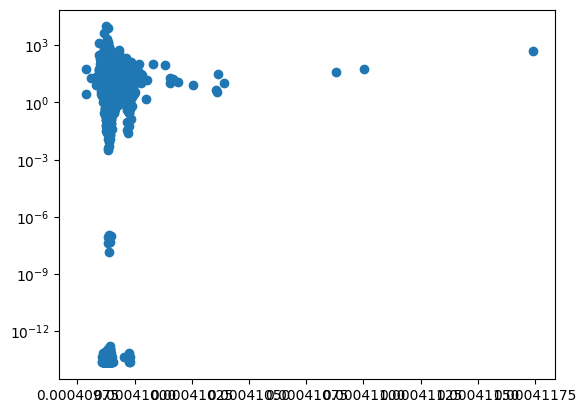

PearsonRResult(statistic=0.015439402671390037, pvalue=2.2053801427697247e-05)

In [77]:
import matplotlib.pyplot as plt
#plt.scatter(bestPredictions, yTest)
plt.scatter(bestPredictions[:,0], yVal.iloc[:,0])
#plt.scatter(bestPredictions[:,1], yVal[:,1])
#plt.xscale("log")
plt.yscale("log")
plt.show()

from scipy.stats import pearsonr
#pearsonr(bestPredictions[:,0], yTest[:,0])
pearsonr(bestPredictions[:,0], yVal.iloc[:,0])
#pearsonr(bestPredictions[:, 1], yVal[:, 1])

In [ ]:
# resPath = "C:\\Users\RobinForMLThesis\\OneDrive - Hanken Svenska handelshogskolan\\Master's_Thesis\\DataAnalysis\\resultsPython.csv"

# finalResults = pd.DataFrame(MSEMatrix)
# pd.DataFrame.to_csv(finalResults, resPath)
# #pd.DataFrame.to_csv(finalResults, "resultsPython.csv")

# MSEMatrix.tofile(resPath, sep = ',')

# finalResults

In [ ]:
MSEMatrix.info(verbose=True)

## Export model comparison

In [312]:
import math

if classification:
    formattedMSEMatrix = MSEMatrix.drop(["ModelPointer"], axis=1)
    formattedMSEMatrix = formattedMSEMatrix.sort_values(by=["accuracy"], axis = 0, ascending=False)
else: 
    formattedMSEMatrix = formattedMSEMatrix.sort_values(by=["mean_absolute_error", "mean_squared_error"], axis = 0)


def RobRound(x): 
    if(x==None or math.isnan(x)): return None
    else: return np.format_float_positional(x, precision=2, unique=False, fractional=False, trim='-', min_digits=None)

def RobRoundFrac(x): 
    if(x==None or math.isnan(x)): return None
    else: return np.format_float_positional(x, precision=3, unique=False, fractional=True, min_digits=None)

def RobRoundTime(x): 
    if(x==None or math.isnan(x)): return None
    else: return np.format_float_positional(x, precision=2, unique=False, fractional=True, min_digits=None)


formattedMSEMatrix["L1"] = formattedMSEMatrix["L1"].apply(lambda x: RobRound(x))
formattedMSEMatrix["L2"] = formattedMSEMatrix["L2"].apply(lambda x: RobRound(x))
formattedMSEMatrix["loss"] = formattedMSEMatrix["loss"].apply(lambda x: RobRoundFrac(x))
formattedMSEMatrix["Learning rate"] = formattedMSEMatrix["Learning rate"].apply(lambda x: RobRound(x))
formattedMSEMatrix["Training Time (minutes)"] = formattedMSEMatrix["Training Time (minutes)"].apply(lambda x: RobRoundTime(float(x)))


if classification:
    formattedMSEMatrix["accuracy"] = formattedMSEMatrix["accuracy"].apply(lambda x: RobRoundFrac(x))
    formattedMSEMatrix["categorical_accuracy"] = formattedMSEMatrix["categorical_accuracy"].apply(lambda x: RobRoundFrac(x))
    formattedMSEMatrix["mean_directional_accuracy"] = formattedMSEMatrix["mean_directional_accuracy"].apply(lambda x: RobRoundFrac(x))
else:
    formattedMSEMatrix["mean_squared_error"] = formattedMSEMatrix["mean_squared_error"].apply(lambda x: RobRoundFrac(x))
    formattedMSEMatrix["mean_absolute_error"] = formattedMSEMatrix["mean_absolute_error"].apply(lambda x: RobRoundFrac(x))


#formattedMSEMatrix = formattedMSEMatrix.fillna(value=np.nan)

from datetime import datetime
now = datetime.now().strftime("%d-%m-%Y_%H%M")
# modelComparisonPathHTML = f"Results//{target}//ModelComparison_" + str(now) + ".html"
# modelComparisonPathCSV = f"Results//{target}//ModelComparison_" + str(now) + ".csv"
modelComparisonPathHTML = f"Results//{target}/{dataSample}/ModelComparison" + ".html"
modelComparisonPathCSV = f"Results//{target}/{dataSample}/ModelComparison" + ".csv"

#pd.DataFrame.to_csv(MSEMatrix, "Results/ModelComparison.csv", index=False)
#pd.DataFrame.to_excel(MSEMatrix, "Results/ModelComparison.xlsx")
pd.DataFrame.to_html(formattedMSEMatrix, modelComparisonPathHTML, index=False)
pd.DataFrame.to_csv(formattedMSEMatrix, modelComparisonPathCSV, index=False)

## Variable importance

In [319]:
# MSEMatrixContinuation = pd.read_csv(modelComparisonPathCSV)


# import os
# rootdir = 'C:/Users/sid/Desktop/test'

# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:
#         print(os.path.join(subdir, file))

models = []
for i in range(5):
    modelPath = f"Results/{target}/{dataSample}/BestKerasModel" + str(i + 1)
    if classification:
        bModel = tf.keras.models.load_model(modelPath, custom_objects={"MDA": MDA})
    else:
        bModel = tf.keras.models.load_model(modelPath)
    models = models + [bModel]

# modelPath = f"Results/{target}/KerasLinearModel"
# OLSModel = tf.keras.models.load_model(modelPath)
# models = models + [OLSModel]



In [346]:
#Variable importance


#rows = len(finalResults["ModelPointer"])
rows = len(models)
cols = len(xVal.columns)
zeroedXVal = np.array(xVal)

#rows = 5

if classification:
    metric = "accuracy"
else:
    metric = "mean_absolute_error"


#VarImpResults = pd.DataFrame(columns = X.columns)
VarImpArray = np.empty((rows, cols), dtype=float, order='C')
normalMSEArray = np.empty((rows, 1), dtype=float, order='C')

for row in range(0, rows):
    
    # model = finalResults["ModelPointer"][row]
    model = models[row]

    loss = model.evaluate(zeroedXVal, yVal, batch_size=128, verbose = 0, return_dict=True)
    normalMSE = loss[metric]
    normalMSEArray[row, 0] = normalMSE

    for col in range(0, cols):

        # print("\n")
        # print("Model ", str(row+1), " out of ", str(rows))
        # print("Variable ", str(col+1), " out of ", str(cols))

        zeroedXVal[:,col] = 0
        #VarImpData[col].values[:] = 0
        loss = model.evaluate(zeroedXVal, yVal, batch_size=128, verbose = 0, return_dict=True)
        zeroedXVal[:,col] = np.array(xVal[xVal.columns[col]])

        try:
            VarImpMSE = loss[metric]
            VarImpArray[row, col] = VarImpMSE
            print("%s on model %s variable %s" % (loss, row+1, col+1))
        except:     
            print("RobError!: Loss is %s on model %s variable %s" % (loss, row+1, col+1))



VarImpResults = pd.DataFrame(VarImpArray, columns = xVal.columns)
normalMSEArray = pd.DataFrame(normalMSEArray, columns = ["AllVariables"])

VarImpResults = pd.concat([VarImpResults, normalMSEArray], axis=1)

VarImpMean = VarImpResults.mean(axis=0)

beep()

{'loss': 1.382115364074707, 'accuracy': 0.3215031325817108, 'categorical_accuracy': 0.3215031325817108, 'mean_directional_accuracy': 0.557411253452301} on model 1 variable 1
{'loss': 1.3818104267120361, 'accuracy': 0.3231993615627289, 'categorical_accuracy': 0.3231993615627289, 'mean_directional_accuracy': 0.5581941604614258} on model 1 variable 2
{'loss': 1.3815374374389648, 'accuracy': 0.3252870440483093, 'categorical_accuracy': 0.3252870440483093, 'mean_directional_accuracy': 0.5587160587310791} on model 1 variable 3
{'loss': 1.382304072380066, 'accuracy': 0.32163360714912415, 'categorical_accuracy': 0.32163360714912415, 'mean_directional_accuracy': 0.5576722621917725} on model 1 variable 4
{'loss': 1.3818154335021973, 'accuracy': 0.3231993615627289, 'categorical_accuracy': 0.3231993615627289, 'mean_directional_accuracy': 0.5583246350288391} on model 1 variable 5
{'loss': 1.3817178010940552, 'accuracy': 0.3233298659324646, 'categorical_accuracy': 0.3233298659324646, 'mean_directiona

In [189]:
import pandas as pd
variableDescriptions = pd.read_excel(
    "Data/CompustatVariableDescriptions/VariableDescriptions.xlsx",
    header=2,
    index_col="N")

variableDescriptions["Variable Name"] = [n.strip() for n in variableDescriptions["Variable Name"]]

import re
variableDescriptions["ShortDescr"] = variableDescriptions["Description"].apply(lambda x : re.sub(r".*-- ", "", x))
#variableDescriptions["ShortDescr"] = variableDescriptions["ShortDescr"].apply(lambda x : re.sub(r" >.*", "", x))
#variableDescriptions["ShortDescr"] = variableDescriptions["ShortDescr"].apply(lambda x : re.sub(r" -.*", "", x))

variableDescriptions["ShortDescr"]

N
1                                    Company Name (CONM)
2                       International Security ID (ISIN)
3                                          SEDOL (SEDOL)
4                            Stock Exchange Code (EXCHG)
5                                  Fiscal Year-End (FYR)
                             ...                        
404    Selling, General and Administrative Expenses (...
405                        Staff Expense - Other (XSTOY)
406                Staff Expense - Wages/Salaries (XSTY)
407                               Expense - Sundry (XSY)
408                                Expense - Total (XTY)
Name: ShortDescr, Length: 408, dtype: object

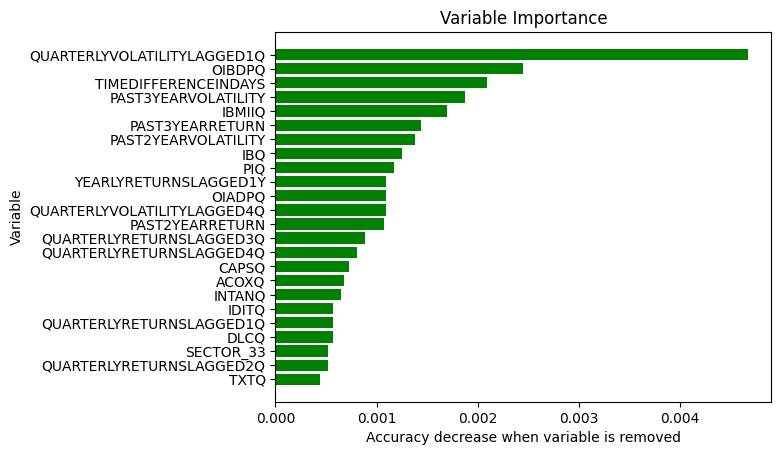

In [348]:
VarImpMean = VarImpResults.mean(axis=0)

if classification:
    VarImpMeanSorted = VarImpMean.sort_values(ascending=True)
    VarImpMeanSorted = VarImpMean["AllVariables"] - VarImpMeanSorted

else:
    VarImpMeanSorted = VarImpMean.sort_values(ascending=False)
    VarImpMeanSorted = VarImpMeanSorted - VarImpMean["AllVariables"]


VarImpMeanSorted = VarImpMeanSorted.rename("Error Increase")
VarImpMeanSorted.index = VarImpMeanSorted.index.str.upper()

# VarImpMeanSorted = pd.merge(
#     VarImpMeanSorted, variableDescriptions, how="left",
#     left_index=True, right_on="Variable Name")

VarImpMeanSorted = pd.DataFrame(VarImpMeanSorted)

pd.DataFrame.to_html(VarImpMeanSorted, f"Results/{target}/{dataSample}/VariableImportance.html", index=False)
pd.DataFrame.to_csv(VarImpMeanSorted, f"Results/{target}/{dataSample}/VariableImportance.csv", index=False)

VarImpMeanBest = VarImpMeanSorted[1:25]
# VarImpMeanScaled = VarImpMeanBest - VarImpMeanBest.mean()

import matplotlib.pyplot as plt

plt.barh(
    VarImpMeanBest.index, VarImpMeanBest["Error Increase"], log=False, color="green")  # , height = 0.4)#, width, bottom=VarImpMean.min(), align)
    #VarImpMeanBest["Variable Name"], VarImpMeanBest["Error Increase"], log=True, color="green")  # , height = 0.4)#, width, bottom=VarImpMean.min(), align)
    #VarImpMeanBest["ShortDescr"], VarImpMeanBest["Error Increase"], log=True, color="green")  # , height = 0.4)#, width, bottom=VarImpMean.min(), align)

plt.gca().invert_yaxis()  # labels read top-to-bottom


plt.title("Variable Importance")
plt.ylabel("Variable")

if classification:
    plt.xlabel("Accuracy decrease when variable is removed")
else:
    plt.xlabel("Error increase when variable is removed")
# plt.legend(['train', 'test'], loc='upper left')


from datetime import datetime
now = datetime.now().strftime("%d-%m-%Y_%H%M")
#variableImportancePath = f"Results/{target}/VariableImportance_" + str(now) + ".png"
variableImportancePath = f"Results/{target}/{dataSample}/VariableImportance" + ".png"

plt.savefig(variableImportancePath)
# from matplotlib.ticker import ScalarFormatter
# plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.show()


In [ ]:
finalData.loc[: ,["returns", "past5YearReturn", "past4YearReturn", "past3YearReturn", "past2YearReturn"]]

## Model visualization

In [352]:
#Visualize network
modelPath = f'Results/{target}/{dataSample}/BestKerasModel1'
if classification:
    bestModel = tf.keras.models.load_model(modelPath, custom_objects={"MDA": MDA})
else:
    bestModel = tf.keras.models.load_model(modelPath)

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

import pydot
import pydotplus
import graphviz

from ann_visualizer.visualize import ann_viz


# from datetime import datetime
# now = datetime.now().strftime("%d-%m-%Y_%H%M")
# learningCurvePath = "Results/LearningCurve_" + str(now) + ".png"

ann_viz(bestModel, view=True, filename=f"Results/{target}/{dataSample}/BestModelVisualized", title="Best Model Visualized")




ValueError: invalid literal for int() with base 10: '169)'

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

bestModel = keras.models.load_model(f'Results/{target}/BestKerasModel1')




#Print summary
modelSummary = bestModel.summary()
print(modelSummary)


# from datetime import datetime
# now = datetime.now().strftime("%d-%m-%Y_%H%M")
# learningCurvePath = "Results/LearningCurve_" + str(now) + ".png"

with open(f'Results/{target}/BestModelSummary.html', 'w') as f:

    bestModel.summary(print_fn=lambda x: f.write(x + '\n'))




# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# import pydot
# import pydotplus
# import graphviz

# tf.keras.utils.plot_model(
#     bestModel,
#     to_file="Results/BestModel.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="LR",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
# )



#pred = model.predict(xWinVal, batch_size=128)

#plt.scatter(pred, yVal)
#pred

## Further training on validation data

In [ ]:
import tensorflow as tf
#from tensorflow import keras
import matplotlib.pyplot as plt


bestModel = tf.keras.models.load_model(f'Results/{target}/BestKerasModel1')
#plot(model)


bestModel = tf.keras.Sequential()
bestModel.add(tf.keras.layers.Dense(units=5, activation="relu"))
bestModel.add(tf.keras.layers.Dropout(0.3))
bestModel.add(tf.keras.layers.Dense(units=5, activation="relu"))
bestModel.add(tf.keras.layers.Dropout(0.3))
bestModel.add(tf.keras.layers.Dense(units=5, activation="relu"))
bestModel.add(tf.keras.layers.Dropout(0.3))
bestModel.add(tf.keras.layers.Dense(units=5, activation="relu"))
bestModel.add(tf.keras.layers.Dropout(0.3))
bestModel.add(tf.keras.layers.Dense(units=1))

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)


bestModel.reset_states()


compiledBestModel = bestModel.compile(optimizer="RMSprop",  # Adam(learning_rate=0.0001) #RMSprop #sgd
                                      loss="MeanSquaredError",  # 'tf.keras.losses.MeanSquaredError()',
                                      metrics=['MeanAbsoluteError'])

bestModel.reset_states()



#xTrainValiPooled = scaled_X[:validationSize,:]
xTrainValiPooled = X.loc[X["Split"]=="Validation", :]
#yTrainValiPooled = Y[:validationSize]
yTrainValiPooled = Y[Y["Split"]=="Validation"]
history = bestModel.fit(x=xTrainValiPooled, y=yTrainValiPooled, batch_size=32,
                        epochs=300, verbose=2, validation_data=(xTest, yTest), callbacks = [callback])



from datetime import datetime
now = datetime.now().strftime("%d-%m-%Y_%H%M")
learningCurvePath = "Results/LearningCurve_" + str(now) + ".png"

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig(learningCurvePath)
plt.show()


# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()




# Keras Tuner

In [ ]:
import keras_tuner as kt

class MyHyperModel(kt.HyperModel):
    def build(self, hp):

        optimizer = hp.Choice("optimizer", ["Adam", "RMSprop"], default="Adam")
        #learning_rate = hp.Float("learning_rate", min_value=0.00001, max_value=0.01, sampling ="reverse_log")
        learning_rate = hp.Choice("learning_rate", [0.005, 0.001, 0.0005], ordered=True, default=0.001)
        # L1 = 0.0
        # L2 = 0.0
        # modelType = hp.Choice("Model_type", ["StandardLinear", "RegularizedLinear", "FeedForward"])
        # with hp.conditional_scope("Model_type", ["RegularizedLinear", "FeedForward"]):
        #     if modelType == "FeedForward" or modelType == "RegularizedLinear":
        #         # L1 = hp.Float("L1", min_value=0.00001, max_value=10, sampling = "log")
        #         # L2 = hp.Float("L2", min_value=0.00001, max_value=10, sampling = "log")
        #         L1 = hp.Choice("L1", (10**np.arange(start=2, stop=-6, step=-1.0)).tolist())
        #         L2 = hp.Choice("L2", (10**np.arange(start=2, stop=-6, step=-1.0)).tolist())

        # with hp.conditional_scope("Model_type", ["FeedForward"]):
        #     if modelType == "FeedForward":
        #         #layers = hp.Int("Layers", min_value=1, max_value=5, sampling = "log")
        #         layers = hp.Int("Layers", min_value=1, max_value=5)
        #         activation = hp.Choice("Activation", ["linear", "relu", "sigmoid", "tanh"])
        #         dropout = hp.Float("Dropout", min_value=0, max_value=0.99)

        #         #layers = hp.Choice("units", (2**np.arange(7)).tolist())
        #         #units = hp.Choice("units", (2**np.arange(7)).tolist())
        #         #units = hp.Int("Units", min_value=1, max_value=2**8, sampling = "log")

        #         units = []
        #         for n in range(0, layers):
        #             with hp.conditional_scope(parent_name="Layers", parent_values=list(range(n+1, layers+1))):
        #                 #units_layer = hp.Int("Units_Layer" + str(n+1), min_value=1, max_value=2**8, sampling = "log")
        #                 units_layer = hp.Int("Units_Layer" + str(n+1), min_value=1, max_value=2**7)
        #                 #print("Hey! " + str(n))
        #                 #units_layer = hp.Choice("Units_Layer" + str(n+1), (2**np.arange(7)).tolist())
        #                 units = units + [units_layer]
        #                 #print("Hey! " + str(units_layer))


        L1 = hp.Choice("L1", (10**np.arange(start=2, stop=-6, step=-1.0)).tolist() + [0.0], default=0.0)
        L2 = hp.Choice("L2", (10**np.arange(start=2, stop=-6, step=-1.0)).tolist() + [0.0], default=0.0)
        max_layers = 5
        layers = hp.Int("Layers", min_value=1, max_value=max_layers, default=1)
        
        if layers > 0: 
            modelType = "FeedForward"
        elif L1 > 0.0 and L2 > 0.0:
            modelType = "RegularizedLinear"
        else:
            modelType = "StandardLinear"


        with hp.conditional_scope("Layers", list(range(1, max_layers+1))):
            if layers > 0:
                activation = hp.Choice("Activation", ["linear", "relu", "sigmoid", "tanh"], default="relu")
                dropout = hp.Float("Dropout", min_value=0, max_value=0.99, default=0)

        # units = []
        # #activation = []
        # dropout = []
        # for m in range(0, layers):
        #     with hp.conditional_scope(parent_name="Layers", parent_values=list(range(m+1, layers+1))):
        #         units_layer = hp.Choice("Units_Layer" + str(m+1), (2**np.arange(7)).tolist(), default=1)
        #         units = units + [units_layer]

        #         #activation_layer = hp.Choice("Activation" + str(m+1), ["linear", "relu", "sigmoid", "tanh"])
        #         #activation = activation + [activation_layer]

        #         dropout_layer = hp.Float("Dropout" + str(m+1), min_value=0, max_value=0.99)
        #         dropout = dropout + [dropout_layer]


        if layers == 3:
            units = [64, 32, 16]
            dropout = [dropout, dropout, dropout]
        elif layers == 4:
            units = [64, 32, 16, 8]
            dropout = [dropout, dropout, dropout, dropout]
        else:
            print("What!?")


        finalActivation = "linear"
        loss = "MeanAbsoluteError"   # 'tf.keras.losses.MeanSquaredError()'  #Huber #MeanAbsoluteError #MeanSquaredError 
        #loss = "MeanSquaredError"   # 'tf.keras.losses.MeanSquaredError()'  #Huber #MeanAbsoluteError #MeanSquaredError 
        metrics = ["MeanAbsoluteError", "MeanSquaredError"] #, "RootMeanSquaredError"]) #accuracy #MeanSquaredLogarithmicError #RootMeanSquaredError #MeanAbsolutePercentageError 
        EarlyStopping_monitor = "val_mean_absolute_error"

        if classification:
            finalActivation = "softmax"
            loss = "categorical_crossentropy"
            metrics = ["accuracy"]
            EarlyStopping_monitor = "val_loss"
        
        # Adam(learning_rate=0.0001) #RMSprop #sgd
        if optimizer == "RMSprop":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        elif optimizer == "Adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)



        #Model creation
        input = tf.keras.layers.Input(shape=(xTrain.shape[1],))
 
        if modelType == "FeedForward":
            try:
                hidden = tf.keras.layers.Dense(units=units[0],
                                activation=activation,
                                kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2))(input)
                hidden = tf.keras.layers.Dropout(rate=dropout[0])(hidden)
                for n in range(0, layers):
                    hidden = tf.keras.layers.Dense(units=units[n],
                                activation=activation,
                                kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2))(hidden)
                    hidden = tf.keras.layers.Dropout(rate=dropout[n])(hidden)
                print(f"NN{layers}Layer")

            except Exception as e: 
                print(e)
                print("NN1Layer_WhyDidWeEndUpHere?")


        outputLayer = tf.keras.layers.Dense(units=yTrain.shape[1], activation=finalActivation,
                                            kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2))

        if modelType == "RegularizedLinear" or modelType == "StandardLinear":
            output = outputLayer(input)
            print("Linear")
        else:
            output = outputLayer(hidden)

        model = tf.keras.models.Model(inputs=[input], outputs=output, name=f"modelType_{runningDate}")

        model.compile(optimizer=optimizer,
                    loss=loss,
                    metrics=metrics)

        return model


    def fit(self, hp, model, *args, **kwargs):
        
        performCV = False
        #Implement cross-validation here

        #tensorboardLogPath = f"Results//NN_KerasTuner_ResultsDir//TensorBoard_{runningDate}"
        #tensorboardLogPath = f"Results/logs/{runningDate}/{modelType}_{layers}L_{units}U_{activation}_{dropout}DO_{L1}L1_{L2}L2_{batch_size}Batch_{optimizer._name}_{learning_rate}LR"
        
        callbacks = kwargs.pop('callbacks')

        return model.fit(
            x=xTrain, y=yTrain,
            batch_size=hp.Choice("batch_size", (2**np.arange(4, 10)).tolist(), default=32), 
            epochs = epochs,
            validation_data=(xVal, yVal),
            steps_per_epoch=500,
            #steps_per_epoch=hp.Choice("batch_size", (2**np.arange(4, 10)).tolist())
            callbacks = callbacks
            # callbacks=[tf.keras.callbacks.EarlyStopping(monitor=EarlyStopping_monitor, patience=patience),
            #    tf.keras.callbacks.TensorBoard(log_dir=tensorboardLogPath)]
        )


objective = "val_mean_absolute_error"
EarlyStopping_monitor = "val_mean_absolute_error"

# objective = "val_mean_squared_error"
# EarlyStopping_monitor = "val_mean_squared_error"


if classification:
    objective = "val_accuracy"
    EarlyStopping_monitor = "val_loss"

epochs = 300
patience = 1 #5
verbose = 1


seed=190
trials:int = 200


hp = kt.HyperParameters()
# This will override the parameters with your own selection of choices
#hp.Int("Layers", min_value=3, max_value=4)
hp.Choice("Layers", [3, 4])
#hp.Float("learning_rate", min_value=0.000005, max_value=0.01, sampling="log")
#hp.Float("learning_rate", min_value=0.000001, max_value=0.01)
hp.Choice("learning_rate", [0.001, 0.01])
#hp.Choice("L1", (10**np.arange(start=2, stop=-6, step=-1.0)).tolist() + [0.0], default=0.0)
#hp.Float("L1", min_value=0, max_value=100)
hp.Float("L1", min_value=0.00001, max_value=0.001)
hp.Float("Dropout", min_value=0, max_value=0.99, default=0)
#hp.Fixed("batch_size", 10000)
hp.Choice("batch_size", [32, 64, 128, 256])

from datetime import datetime
runningDate = datetime.now().strftime("%d-%m-%Y_%H%M") #comment out to continue from previous

# tuner = kt.RandomSearch(
#     MyHyperModel(),
#     objective=objective,
#     max_trials=trials,
#     overwrite=True,
#     seed=seed,
#     hyperparameters=hp,
#     tune_new_entries=False,
#     # allow_new_entries=True,
#     directory="Results//NN_KerasTuner_ResultsDir",
#     project_name=f"tune_hypermodel_{runningDate}"
# )

#keras_tuner.SklearnTuner(oracle, hypermodel, scoring=None, metrics=None, cv=None, **kwargs)

# tuner = kt.Hyperband(
#     hypermodel=MyHyperModel(),
#     objective=objective,
#     overwrite=True,
#     seed=seed,
#     hyperparameters=None,
#     tune_new_entries=True,
#     allow_new_entries=True,
#     directory="Results//NN_KerasTuner_ResultsDir",
#     project_name=f"tune_hypermodel_{runningDate}"
# )

tuner = kt.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=objective,
    max_trials=trials,
    #overwrite=True,
    #num_initial_points=2,
    #alpha=0.0001,
    #beta=2.6,
    seed=seed,
    hyperparameters=hp,
    tune_new_entries=False,
    #allow_new_entries=True,
    directory="Results//NN_KerasTuner_ResultsDir",
    project_name=f"tune_hypermodel_{runningDate}_v3"
)



tensorboardLogPath = f"Results//NN_KerasTuner_ResultsDir//tune_hypermodel_{runningDate}//TensorBoard"
tuner.search(
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor=EarlyStopping_monitor, patience=patience)]#, tf.keras.callbacks.TensorBoard(log_dir=tensorboardLogPath)]
)

bestHPs = tuner.get_best_hyperparameters(num_trials=trials)
bestHPs[0].values

bestModel = tuner.get_best_models(num_models=1)


Trial 200 Complete [00h 00m 10s]
val_mean_absolute_error: 15.432453155517578

Best val_mean_absolute_error So Far: 15.431215286254883
Total elapsed time: 01h 00m 30s
INFO:tensorflow:Oracle triggered exit
NN3Layer


In [ ]:
str(round((1 - 15.431215286254883/zeroForecastMAE)*100, 5)) + "%"

'0.00453%'

In [ ]:
tuner.results_summary(10)

Results summary
Results in Results//NN_KerasTuner_ResultsDir\tune_hypermodel_23-01-2023_0129_v3
Showing 10 best trials
Trial summary
Hyperparameters:
Layers: 3
learning_rate: 0.01
L1: 0.00048676815782853344
Dropout: 0.99
batch_size: 32
optimizer: Adam
L2: 0.0
Activation: relu
Score: 15.431215286254883
Trial summary
Hyperparameters:
Layers: 3
learning_rate: 0.01
L1: 0.001
Dropout: 0.99
batch_size: 32
optimizer: Adam
L2: 0.0
Activation: relu
Score: 15.431517601013184
Trial summary
Hyperparameters:
Layers: 3
learning_rate: 0.001
L1: 1e-05
Dropout: 0.99
batch_size: 128
optimizer: Adam
L2: 0.0
Activation: relu
Score: 15.43159294128418
Trial summary
Hyperparameters:
Layers: 3
learning_rate: 0.001
L1: 0.001
Dropout: 0.99
batch_size: 128
optimizer: Adam
L2: 0.0
Activation: relu
Score: 15.431756019592285
Trial summary
Hyperparameters:
Layers: 3
learning_rate: 0.001
L1: 0.001
Dropout: 0.99
batch_size: 128
optimizer: Adam
L2: 0.0
Activation: relu
Score: 15.431771278381348
Trial summary
Hyperparam

### Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir tensorboardLogPath

#http://localhost:6006/

# The rest

In [ ]:
#ynew = model.predict_classes(Xnew)

In [ ]:
#(Geron 2019, 76, 320)

#from sklearn import RandomizedSearchCV, GridSearchCV



#(Geron 2019, 76)
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)



grid_search.best_params_

grid_search.best_estimator_

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)





#(Geron 2019, 320)


def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model


keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


keras_reg.fit(X_train, y_train, epochs=100,
validation_data=(X_valid, y_valid),
callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)




from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=100,
validation_data=(X_valid, y_valid),
callbacks=[keras.callbacks.EarlyStopping(patience=10)])


rnd_search_cv.best_params_
rnd_search_cv.best_score_
model = rnd_search_cv.best_estimator_.model








#Chollet: DL for Python
import kerastuner as kt





#strategy = tf.distribute.MirroredStrategy()





#If your search process crashes, you can always restart it—just specify overwrite=False in the tuner so that it can resume from the trial logs stored on disk.




